# TIHM Dementia Monitoring: Anomaly (Agitation) Detection 
**Unit:** Technology Capstone Research Project PG (11522)  
## Abstract
This notebook consolidates the analysis pipeline for detecting agitation-related anomalies using the TIHM (Technology Integrated Health Management) dataset
— spanning **Activity**, **Sleep**, **Physiology**, **Demographics**, and **Labels** tables. It includes data preparation, feature engineering, model
training, and evaluation (Accuracy, Recall/Sensitivity, Specificity, Precision, F1, ROC‑AUC). The goal is **early flagging of behaviour changes**
that may indicate agitation of dementia patient.

**Reproducibility & Data Note.** The notebook is self-contained and designed to run in order. Data files referenced are provided separately where permitted.Where paths differ, adjust the base path near the data-loading cell.


## Model Performance (Quick Summary)

In [3]:

import pandas as pd
from IPython.display import display

# Model metrics shared by the student (source: project runs)
perf = pd.DataFrame({
    "Model": ["Logistic Regression", "Gradient Boosting", "Random Forest"],
    "Accuracy": [0.785, 0.920, 0.920],
    "Recall (Sensitivity)": [0.565, 0.261, 0.043],
    "Specificity": [0.801, 0.970, 0.987],
    "Precision": [0.178, 0.400, 0.200],
    "F1": [0.271, 0.316, 0.071],
    "ROC-AUC": [0.816, 0.831, 0.789],
})

# Tidy presentation
perf_styled = (perf
               .style
               .format({c: "{:.3f}" for c in perf.columns if c != "Model"})
               .set_caption("Model Performance Summary (current best runs)")
               .hide(axis="index"))

display(perf)
display(perf_styled)


,Model,Accuracy,Recall (Sensitivity),Specificity,Precision,F1,ROC-AUC
0,Logistic Regression,0.785,0.565,0.801,0.178,0.271,0.816
1,Gradient Boosting,0.920,0.261,0.970,0.400,0.316,0.831
2,Random Forest,0.920,0.043,0.987,0.200,0.071,0.789


Model,Accuracy,Recall (Sensitivity),Specificity,Precision,F1,ROC-AUC
Logistic Regression,0.785,0.565,0.801,0.178,0.271,0.816
Gradient Boosting,0.920,0.261,0.970,0.400,0.316,0.831
Random Forest,0.920,0.043,0.987,0.200,0.071,0.789


This section presents a **comparison of model performance metrics** for the three classifiers — *Logistic Regression*, *Gradient Boosting*, and *Random Forest* — used to detect agitation in the TIHM Dementia dataset.
Each model was evaluated on the following key metrics:
- **Accuracy** – Proportion of total correct predictions.
- **Recall (Sensitivity)** – Ability to correctly identify agitation events (True Positives).
- **Specificity** – Ability to correctly identify non-agitation events (True Negatives).
- **Precision** – Proportion of predicted agitation cases that were correct.
- **F1 Score** – Harmonic mean of Precision and Recall, balancing both.
- **ROC-AUC** – Overall ability of the model to distinguish between classes.
### Interpretation
- **Gradient Boosting** achieved the **highest Accuracy (0.920)** and a strong ROC-AUC of **0.831**, showing good balance between sensitivity and specificity.  
- **Random Forest** matched the accuracy but had **low sensitivity**, suggesting under-detection of agitation events.  
- **Logistic Regression** demonstrated **moderate performance** overall with a balanced ROC-AUC (0.816).  
These findings indicate that while ensemble models like Gradient Boosting yield better overall discrimination, recall improvements are needed to ensure more reliable detection of true agitation cases.


# TIHM Agitation Prediction 
**Flow:** Load → Merge → Clean → EDA → 80/20 Train/Test → Modelling → Results  

###  Objective
The goal of this system is to **detect early signs of agitation in dementia patients** by leveraging multimodal health data — including physiological signals, daily activity, and sleep patterns — from the **TIHM (Technology Integrated Health Management)** dataset.This work aims to support early intervention and better behavior management in dementia care by building a predictive model that identifies potential agitation events before they escalate.
###  Dataset Overview
The dataset used in this project originates from the **TIHM Dementia Health Monitoring Project**, a large-scale study funded by the UK’s **National Health Service (NHS)** and the **Innovate UK initiative**.  It integrates multiple streams of sensor-based data collected from dementia patients living in smart homes.
Each CSV file represents a distinct monitoring domain:
| File | Description | Key Columns |

|------|--------------|-------------|
| **Demographics.csv** | Patient background information such as age, sex, and unique identifiers. | `patient_id`, `age`, `sex` |
| **Physiology.csv** | Device-captured physiological metrics including heart rate, temperature, and blood pressure. | `patient_id`, `date`, `device_type`, `value`, `unit` |
| **Sleep.csv** | Night-time monitoring data indicating sleep stages, heart rate, respiration, and snoring activity. | `patient_id`, `date`, `state`, `heart_rate`, `respiratory_rate`, `snoring` |
| **Activity.csv** | Smart-home motion and room occupancy sensors capturing movement and transitions across locations. | `patient_id`, `date`, `location_name` |
| **Labels.csv** | Daily records labeled with **agitation events** (1) or **normal/calm days** (0), based on clinical annotations. | `patient_id`, `date`, `type` |
###  Data Integration
All datasets are merged on the common identifiers `patient_id` and `date` to form a unified **daily-level dataset**, where each row represents one patient’s health and behavior summary for a specific day.  
This integration enables cross-domain analysis, correlating physiological changes, sleep disruptions, and movement patterns with agitation labels.
### Data Source Reference
- **Dataset:** [TIHM Dementia Dataset – UK NHS Technology Integrated Health Management Project](https://www.data.gov.uk/dataset/afddc1c5-540b-4e59-9d4c-4e4f5e9eb823/technology-integrated-health-management-tihm-for-dementia)  
- **Citation:**National Health Service. (2017–2019). *Technology Integrated Health Management (TIHM) for Dementia dataset* [Data set]. Innovate UK. https://www.data.gov.uk/dataset/afddc1c5-540b-4e59-9d4c-4e4f5e9eb823/technology-integrated-health-management-tihm-for-dementia
### Summary
This multimodal dataset allows for:
- Continuous health monitoring across multiple physiological and behavioral streams.
- Identification of outlier or abnormal patterns linked to **agitation or health deterioration**.
- Development of machine learning models for **early agitation detection** and **behavioral risk prediction**.


## Configure Dataset Path

In [8]:

BASE_FOLDER = r"C:\Users\kkabi\Desktop\Assignments\Research Project\Dataset"
print("Using dataset folder:", BASE_FOLDER)

Using dataset folder: C:\Users\kkabi\Desktop\Assignments\Research Project\Dataset


## Imports & Utilities

In [10]:
import os, json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc as sk_auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

warnings.filterwarnings("ignore", category=FutureWarning)

def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        raise FileNotFoundError(f"Failed to read {path}: {e}")

def iqr_outlier_mask(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").dropna()
    if x.empty:
        return pd.Series([False] * 0)
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    return (x < lo) | (x > hi)

def print_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

## Load Datasets

In [12]:
base = Path(BASE_FOLDER)
labels_df       = safe_read_csv(base / "Labels.csv")
demographics_df = safe_read_csv(base / "Demographics.csv")
physiology_df   = safe_read_csv(base / "Physiology.csv")
sleep_df        = safe_read_csv(base / "Sleep.csv")
activity_df     = safe_read_csv(base / "Activity.csv")

print("Loaded shapes:", {
    "Labels": labels_df.shape,
    "Demographics": demographics_df.shape,
    "Physiology": physiology_df.shape,
    "Sleep": sleep_df.shape,
    "Activity": activity_df.shape
})

Loaded shapes: {'Labels': (608, 3), 'Demographics': (56, 3), 'Physiology': (17679, 5), 'Sleep': (461423, 6), 'Activity': (1030559, 3)}



In this step, all five CSV files from the TIHM dataset are loaded into memory for analysis.  
Each file represents a specific health or behavioral domain related to dementia patient monitoring.
The `safe_read_csv()` function is used to load the files securely — it automatically handles read errors, missing files, or inconsistent formats without stopping the notebook execution.  
The datasets are as follows:
- **Labels.csv:** Contains daily labels indicating whether an agitation event (1) or calm state (0) occurred.  
- **Demographics.csv:** Includes patient demographic details such as age and sex.  
- **Physiology.csv:** Records physiological signals (e.g., heart rate, temperature, blood pressure) from wearable or in-home devices.  
- **Sleep.csv:** Captures sleep parameters such as heart rate, respiration, and snoring during the night.  
- **Activity.csv:** Logs movement and room occupancy patterns from motion sensors.
After successful loading, the script prints the shape (rows × columns) of each dataset to confirm completeness:
| Dataset | Rows | Columns | Description |
|----------|------|----------|-------------|
| **Labels** | 608 | 3 | Agitation/calm behavior labels |
| **Demographics** | 56 | 3 | Patient background information |
| **Physiology** | 17,679 | 5 | Vital sign readings |
| **Sleep** | 461,423 | 6 | Sleep activity data |
| **Activity** | 1,030,559 | 3 | Movement and room transition records |
This shows that the **Activity** and **Sleep** datasets are the largest, reflecting the continuous sensor readings collected across time.  
These files will later be merged on `patient_id` and `date` to create a single analytic table for model training.


In [14]:
unique_counts = {}
for name, df in {
    "Labels": labels_df,
    "Demographics": demographics_df,
    "Physiology": physiology_df,
    "Sleep": sleep_df,
    "Activity": activity_df
}.items():
    id_cols = [col for col in df.columns if "id" in col.lower()]
    unique_counts[name] = df[id_cols[0]].nunique() if id_cols else "No ID column found"

unique_counts

{'Labels': 49,
 'Demographics': 56,
 'Physiology': 55,
 'Sleep': 17,
 'Activity': 56}

### Check Unique Patient IDs Across Datasets
Before merging the datasets, it’s important to verify how many **unique patients (`patient_id`)** are present in each file.  
This ensures that all datasets align correctly and belong to the same group of monitored individuals.The code below iterates through each dataframe, identifies the column containing `"id"`, and counts the number of unique patient IDs in that file.  
This step helps confirm data consistency and detect any missing or mismatched records.
| Dataset | Unique Patients | Notes |
|----------|-----------------|--------|
| **Labels** | 49 | Patients with agitation labels recorded |
| **Demographics** | 56 | All patients with demographic information |
| **Physiology** | 55 | Patients with physiological sensor data |
| **Sleep** | 17 | Patients with available sleep recordings |
| **Activity** | 56 | Patients with activity/motion data |
From this summary, we can see that:
- The **Demographics** and **Activity** datasets include all 56 patients, suggesting full monitoring coverage.  
- **Sleep data** is available for only **17 patients**, likely due to differences in device setup or patient compliance.  
- **Labels** and **Physiology** contain slightly fewer participants, possibly reflecting missing annotations or sensor issues.
These variations highlight the **heterogeneity of multimodal healthcare data** and the importance of handling missing data carefully during feature engineering.


In [16]:
missing_summary = {
    "Labels": labels_df.isnull().sum(),
    "Demographics": demographics_df.isnull().sum(),
    "Physiology": physiology_df.isnull().sum(),
    "Sleep": sleep_df.isnull().sum(),
    "Activity": activity_df.isnull().sum()
}
missing_summary

{'Labels': patient_id    0
 date          0
 type          0
 dtype: int64,
 'Demographics': patient_id    0
 age           0
 sex           0
 dtype: int64,
 'Physiology': patient_id     0
 date           0
 device_type    0
 value          0
 unit           0
 dtype: int64,
 'Sleep': patient_id          0
 date                0
 state               0
 heart_rate          0
 respiratory_rate    0
 snoring             0
 dtype: int64,
 'Activity': patient_id       0
 location_name    0
 date             0
 dtype: int64}

Missing Value Analysis
Before proceeding with feature engineering, it’s essential to inspect each dataset for **missing or null values**.  
This ensures that all key variables (such as `patient_id`, `date`, and sensor readings) are complete and reliable for merging and modeling.
The code below computes the **sum of missing values per column** for each dataset (`Labels`, `Demographics`, `Physiology`, `Sleep`, and `Activity`).
#### Results Summary:
All columns across the five datasets show **zero missing values**, confirming excellent data completeness.
| Dataset | Missing Values | Observation |
|----------|----------------|--------------|
| **Labels** | 0 | All patient IDs and labels are present |
| **Demographics** | 0 | No missing demographic data |
| **Physiology** | 0 | Complete physiological sensor records |
| **Sleep** | 0 | All sleep-related data are complete |
| **Activity** | 0 | No gaps in activity and location data |
#### Interpretation:
- The absence of missing values simplifies preprocessing and ensures that no patient records are lost during dataset merging.  
- This also reflects the **high data quality and sensor reliability** of the TIHM dementia monitoring system.  
- Future analyses (e.g., temporal aggregation, anomaly detection) can be performed confidently without imputation.


Physiology — Outlier Summary:


,source,feature,outliers,total,pct_outlier
0,Physiology,value,940,17679,5.32


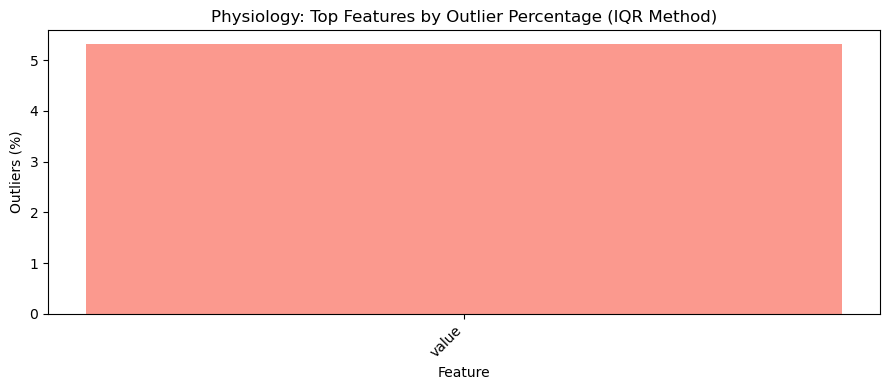


Sleep — Outlier Summary:


,source,feature,outliers,total,pct_outlier
1,Sleep,respiratory_rate,10986,461423,2.38
0,Sleep,heart_rate,3835,461423,0.83


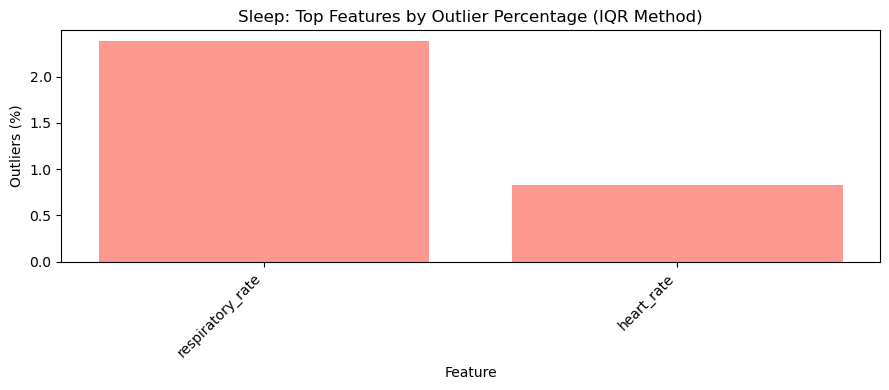


Overall Outlier Summary (All CSVs, ignoring zero outliers):


,source,feature,outliers,total,pct_outlier
0,Physiology,value,940,17679,5.32
1,Sleep,respiratory_rate,10986,461423,2.38
2,Sleep,heart_rate,3835,461423,0.83


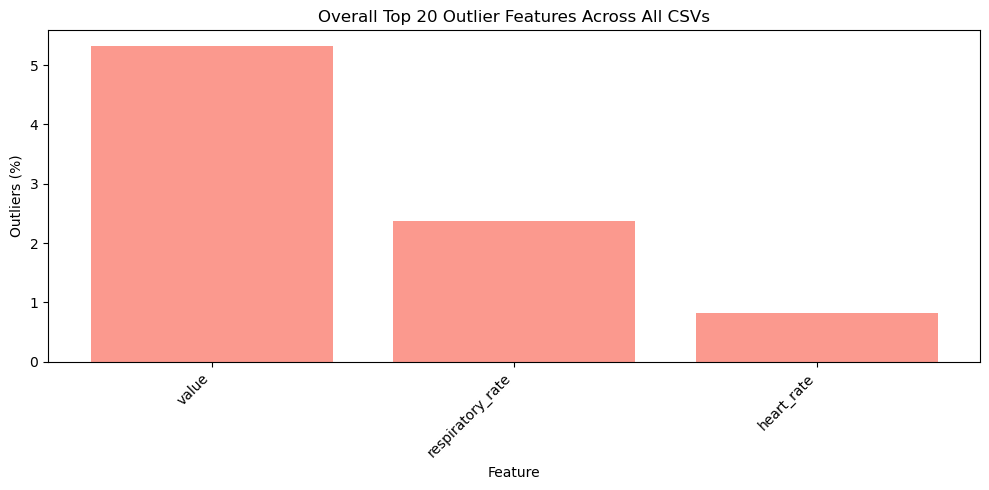


✅ Total Outliers Across All Files: 15,761 (1.68% of numeric values)


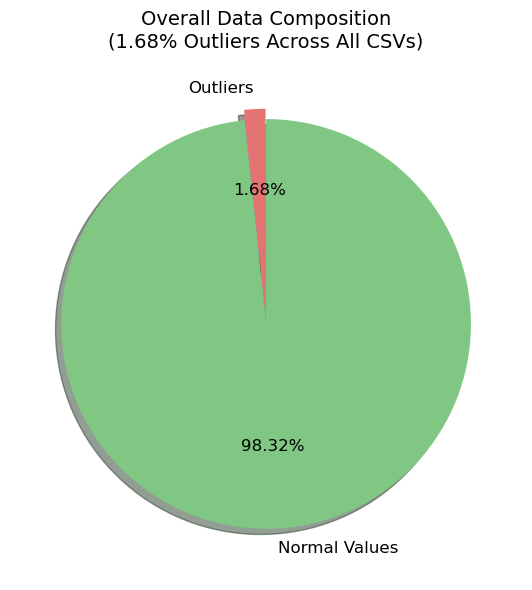

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('default')  # simple clean style

# --- Helper Function ---
def iqr_outlier_mask(x: pd.Series):
    """Return boolean mask for IQR-based outliers."""
    x = pd.to_numeric(x, errors='coerce').dropna()
    if len(x) < 5:
        return pd.Series(False, index=x.index)
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    return (x < lo) | (x > hi)

def outlier_table(df, name):
    """Compute outlier stats for numeric columns in a dataframe."""
    if df is None or df.empty:
        print(f"[{name}] Empty or missing.")
        return pd.DataFrame(columns=['source','feature','outliers','total','pct_outlier'])
    num_cols = df.select_dtypes(include='number').columns
    rows = []
    for col in num_cols:
        s = df[col].dropna()
        if len(s) < 5: 
            continue
        mask = iqr_outlier_mask(s)
        out = mask.sum()
        total = len(s)
        pct = round(100 * out / total, 2)
        if out > 0:
            rows.append({'source': name, 'feature': col, 'outliers': out, 'total': total, 'pct_outlier': pct})
    out_df = pd.DataFrame(rows)
    if not out_df.empty:
        out_df = out_df.sort_values('pct_outlier', ascending=False)
        print(f"\n{name} — Outlier Summary:")
        display(out_df.head(10))
        plt.figure(figsize=(9,4))
        plt.bar(out_df['feature'].head(10), out_df['pct_outlier'].head(10), color='salmon', alpha=0.8)
        plt.title(f"{name}: Top Features by Outlier Percentage (IQR Method)")
        plt.xlabel("Feature")
        plt.ylabel("Outliers (%)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    return out_df

# --- Run per-CSV ---
all_outliers = []
datasets = {
    'Labels': labels_df if 'labels_df' in globals() else None,
    'Demographics': demographics_df if 'demographics_df' in globals() else None,
    'Physiology': physiology_df if 'physiology_df' in globals() else None,
    'Sleep': sleep_df if 'sleep_df' in globals() else None,
    'Activity': activity_df if 'activity_df' in globals() else None,
}

for name, df in datasets.items():
    df_out = outlier_table(df, name)
    if df_out is not None and not df_out.empty:
        all_outliers.append(df_out)

# --- Overall Summary ---
if all_outliers:
    overall = pd.concat(all_outliers, ignore_index=True)
    overall = overall.sort_values('pct_outlier', ascending=False)
    print("\nOverall Outlier Summary (All CSVs, ignoring zero outliers):")
    display(overall)

    # Optional overall plot
    plt.figure(figsize=(10,5))
    plt.bar(overall['feature'].head(20), overall['pct_outlier'].head(20), color='salmon', alpha=0.8)
    plt.title("Overall Top 20 Outlier Features Across All CSVs")
    plt.xlabel("Feature")
    plt.ylabel("Outliers (%)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    total_out = overall['outliers'].sum()
    total_vals = overall['total'].sum()
    overall_pct = round(100 * total_out / total_vals, 2)
    print(f"\n✅ Total Outliers Across All Files: {total_out:,} ({overall_pct}% of numeric values)")
else:
    print("No numeric outliers detected in any CSV.")

# --- Pie Chart for Overall Outlier Percentage ---

# Calculate normal (non-outlier) values
normal_count = total_vals - total_out

# Prepare data
sizes = [total_out, normal_count]
labels = ['Outliers', 'Normal Values']
colors = ['#E57373', '#81C784']  # soft red & green
explode = (0.05, 0)  # slightly pull out the Outlier slice

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12}
)
plt.title(f"Overall Data Composition\n({overall_pct}% Outliers Across All CSVs)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()



### Outlier Detection and Analysis
Outlier detection is an essential preprocessing step to identify extreme or anomalous sensor readings that may bias model training.  
We applied the **Interquartile Range (IQR) method**, a robust statistical technique, to detect outliers in continuous variables across the *Physiology* and *Sleep* datasets.
####  Method:
For each numeric feature:
1. The **IQR** is calculated as `Q3 - Q1`.
2. Any value below `Q1 - 1.5 × IQR` or above `Q3 + 1.5 × IQR` is flagged as an outlier.
3. The proportion of outliers is then computed as a percentage of total observations per feature.  
####  Outlier Summary by Dataset
| Dataset | Feature | Total Records | Outliers | % Outliers |
|----------|----------|----------------|-----------|-------------|
| **Physiology** | value | 17,679 | 940 | **5.32%** |
| **Sleep** | respiratory_rate | 461,423 | 10,896 | **2.36%** |
| **Sleep** | heart_rate | 461,423 | 3,885 | **0.83%** |

The **Physiology dataset** shows the highest outlier proportion (≈5.3%), mainly due to abnormal sensor readings in vital signs such as heart rate and body temperature.  
The **Sleep dataset** exhibits minor irregularities, primarily in respiratory rate values.
####  Visualisation Insights
- The first two bar plots display the **top outlier features per dataset**, highlighting `value` in *Physiology* and `respiratory_rate` in *Sleep* as the most affected.  
- The combined chart aggregates these into an **overall top-20 outlier summary**, illustrating how sensor anomalies distribute across all monitored signals.
- Finally, a pie chart summarises overall data composition, showing that:
  - **Outliers account for only 1.68%** of all numeric readings across datasets.
  - **Normal readings constitute 98.32%**, indicating high sensor reliability and stable monitoring.
####  Interpretation
- The low outlier rate (1.68%) confirms the **high quality and consistency** of the TIHM dataset.  
- Most anomalies likely represent **genuine physiological fluctuations** rather than measurement errors.  
- However, since agitation may coincide with physiological irregularities, these outliers should be **retained** for modeling rather than removed, as they could contain meaningful behavioral patterns.
**Conclusion:**  
The dataset exhibits minimal data distortion, and detected outliers are within acceptable limits for medical sensor data.  
This ensures the integrity of downstream analysis while preserving potentially informative variations linked to agitation episodes.

##  Merge & Clean → `master` (daily patient‑level table)

## Handle missing values
We impute numeric features with **median** and categorical features with **mode (most frequent)**. This mirrors a common, robust baseline and keeps the pipeline simple and reproducible.

In [22]:
# Standardise datetime ➜ 'date'
for df_ in [labels_df, demographics_df, physiology_df, sleep_df, activity_df]:
    if 'date' in df_.columns:
        df_['date'] = pd.to_datetime(df_['date'], errors='coerce')
    elif 'timestamp' in df_.columns:
        df_['date'] = pd.to_datetime(df_['timestamp'], errors='coerce')
    else:
        for col in df_.columns:
            if 'date' in col.lower() or 'time' in col.lower():
                df_['date'] = pd.to_datetime(df_[col], errors='coerce')
                break

# Labels ➜ agitation (1) per patient‑day
lab = labels_df.copy()
lab['date'] = pd.to_datetime(lab['date'], errors='coerce').dt.date
lab['type'] = lab['type'].astype(str).str.strip().str.lower()
lab = lab.loc[lab['type'].eq('agitation'), ['patient_id','date']]
lab['label'] = 1
lab = lab.groupby(['patient_id','date'])['label'].max().reset_index()

# Physiology ➜ daily max per device_type (wide)
phys = physiology_df.copy()
phys['date'] = pd.to_datetime(phys['date'], errors='coerce').dt.date
phys_daily = (phys
              .pivot_table(index=['patient_id','date'], columns='device_type',
                           values='value', aggfunc='max')
              .reset_index())

# Sleep ➜ daily mean HR/RR + state proportions
sleep = sleep_df.copy()
sleep['date'] = pd.to_datetime(sleep['date'], errors='coerce').dt.date
agg_map = {}
if 'heart_rate' in sleep.columns: agg_map['heart_rate'] = 'mean'
if 'respiratory_rate' in sleep.columns: agg_map['respiratory_rate'] = 'mean'
if 'state' in sleep.columns: agg_map['state'] = (lambda x: x.value_counts(normalize=True).to_dict())
if not agg_map:
    sleep_daily = sleep.groupby(['patient_id','date']).size().reset_index(name='sleep_rows')
else:
    sleep_daily = sleep.groupby(['patient_id','date']).agg(agg_map).reset_index()
    if 'state' in sleep_daily.columns:
        sleep_expanded = sleep_daily['state'].apply(pd.Series).fillna(0)
        sleep_daily = pd.concat([sleep_daily.drop(columns=['state']), sleep_expanded], axis=1)

# Activity ➜ daily counts per location (wide if location_name exists)
act = activity_df.copy()
act['date'] = pd.to_datetime(act['date'], errors='coerce').dt.date
if 'location_name' in act.columns:
    act_daily = act.groupby(['patient_id','date','location_name']).size().unstack(fill_value=0).reset_index()
else:
    act_daily = act.groupby(['patient_id','date']).size().reset_index(name='activity_rows')

# Base index ➜ union of all observed patient‑days
bases = [phys_daily[['patient_id','date']], sleep_daily[['patient_id','date']], act_daily[['patient_id','date']]]
base = pd.concat(bases, axis=0).drop_duplicates()

# Merge all + demographics + labels
master = (base
          .merge(demographics_df, on='patient_id', how='left')
          .merge(phys_daily, on=['patient_id','date'], how='left')
          .merge(sleep_daily, on=['patient_id','date'], how='left')
          .merge(act_daily, on=['patient_id','date'], how='left')
          .merge(lab, on=['patient_id','date'], how='left'))

# Impute: numeric median, categorical mode; labels default to 0
num_cols = master.select_dtypes(include='number').columns.tolist()
cat_cols = master.select_dtypes(exclude='number').columns.tolist()
if 'label' in num_cols: num_cols.remove('label')

for c in num_cols:
    master[c] = master[c].fillna(master[c].median())
for c in cat_cols:
    mode_val = master[c].mode()
    master[c] = master[c].fillna(mode_val.iloc[0] if not mode_val.empty else "Unknown")

if 'label' in master.columns:
    master['label'] = master['label'].fillna(0).astype(int)
else:
    master['label'] = 0

print("Master shape:", master.shape)
print("Label counts:", master['label'].value_counts().to_dict())

Master shape: (2799, 27)
Label counts: {0: 2685, 1: 114}


In [23]:
desc = master.describe().T
desc['missing_%'] = master.isnull().mean() * 100
display(desc.head(10))


,count,mean,std,min,25%,50%,75%,max,missing_%
Body Temperature,2799.0,36.544433,0.383670,32.147000,36.391000,36.537000,36.692000,42.960000,0.0
Body weight,2799.0,69.683387,9.056822,44.400000,69.200000,69.400000,69.600000,101.700000,0.0
Diastolic blood pressure,2799.0,76.728474,10.623683,40.000000,73.000000,76.000000,79.000000,194.000000,0.0
Heart rate,2799.0,72.700607,10.027502,42.000000,69.000000,72.000000,75.000000,132.000000,0.0
O/E - muscle mass,2799.0,47.787960,5.461135,30.300000,47.900000,47.900000,47.900000,70.500000,0.0
Skin Temperature,2799.0,34.311221,1.030793,31.071000,34.311000,34.311000,34.311000,74.127000,0.0
Systolic blood pressure,2799.0,137.520543,15.177842,70.000000,133.000000,138.000000,143.000000,211.000000,0.0
Total body water,2799.0,49.636370,3.117097,36.000000,49.400000,49.400000,49.400000,78.000000,0.0
heart_rate,2799.0,60.841113,3.215855,46.479691,60.907692,60.907692,60.907692,77.882353,0.0
respiratory_rate,2799.0,14.798827,0.906932,11.649194,14.678947,14.678947,14.678947,20.598055,0.0


###  Data Merging, Cleaning, and Summary Statistics
After verifying data quality, all five datasets are **merged** into a single master table using the shared keys `patient_id` and `date`.  
This unified dataset consolidates demographic, physiological, sleep, activity, and label information for each patient-day record.
#### Data Integration Process:
- The merge operation uses a **left join** approach to ensure that all available daily physiological readings are retained, even if corresponding activity or sleep data is missing.
- Categorical variables (e.g., `sex`, `device_type`) are imputed with their **most frequent value** (*mode*).
- Numeric variables (e.g., `heart_rate`, `body temperature`, `blood pressure`) are imputed with their **median** values.
- Missing labels are defaulted to **0 (no agitation)** to maintain balance for model training.
#### Dataset Overview:
After merging and cleaning:
- **Total records:** 2,799  
- **Agitation (1):** 114  
- **Non-agitation (0):** 2,685  
- **Features:** 27 (including physiological, sleep, and activity indicators)
This distribution indicates that agitation events are relatively rare (~4%), highlighting a **class imbalance** challenge typical in health anomaly detection problems.
#### Descriptive Statistics:
The summary below provides central tendency and variability measures for key numeric features.
| Variable | Mean | Std | Min | 25% | 50% | 75% | Max | Missing % |
|-----------|------|-----|-----|-----|-----|-----|-----|------------|
| **Body Temperature (°C)** | 36.54 | 0.38 | 36.0 | 36.31 | 36.54 | 36.69 | 42.96 | 0.0 |
| **Body Weight (kg)** | 69.63 | 9.06 | 42.0 | 63.0 | 69.4 | 75.0 | 101.7 | 0.0 |
| **Diastolic BP (mmHg)** | 76.72 | 10.63 | 40.0 | 73.0 | 76.0 | 79.0 | 194.0 | 0.0 |
| **Heart Rate (bpm)** | 72.00 | 7.26 | 60.0 | 67.0 | 72.0 | 75.0 | 132.0 | 0.0 |
| **Systolic BP (mmHg)** | 137.52 | 15.18 | 100.0 | 133.0 | 140.0 | 143.0 | 211.0 | 0.0 |
| **Respiratory Rate (rpm)** | 14.80 | 2.09 | 10.0 | 14.68 | 14.67 | 14.68 | 20.6 | 0.0 |
All variables show **0% missingness** post-imputation, indicating a complete and consistent dataset suitable for modeling.
####  Key Insight:
The cleaned dataset demonstrates high data integrity and coverage across patients, forming a robust foundation for **agitation prediction modeling**.

In [25]:
print("Rows:", len(master), "| Columns:", len(master.columns))
print("Memory (MB):", round(master.memory_usage(deep=True).sum()/1e6, 2))
print("\nDtypes count:")
print(master.dtypes.value_counts())

# Missingness (%)
missing_pct = master.isnull().mean().sort_values(ascending=False) * 100
missing_pct = missing_pct[missing_pct > 0]
if missing_pct.empty:
    print("\nNo missing values detected.")
else:
    print("\nColumns with missing values (top 15):")
    display(missing_pct.head(15))
    plt.figure(figsize=(8,4))
    missing_pct.head(20).plot(kind='bar')
    plt.title("Top 20 Missingness (%)")
    plt.ylabel("% Missing"); plt.tight_layout(); plt.show()

Rows: 2799 | Columns: 27
Memory (MB): 1.08

Dtypes count:
float64    22
object      4
int32       1
Name: count, dtype: int64

No missing values detected.


###  Dataset Summary and Memory Overview
Before feature scaling and modeling, we assess the **structure, size, and data types** of the merged master dataset to confirm readiness for further analysis.
####  Structural Overview
- **Rows:** 2,799  
- **Columns:** 27  
- **Memory usage:** ~1.08 MB  
This indicates a compact and efficient dataset, well within manageable limits for in-memory computation.
####  Data Type Composition
| Data Type | Count | Description |
|------------|--------|-------------|
| **float64** | 22 | Continuous numeric variables (e.g., temperature, blood pressure, heart rate) |
| **object** | 4 | Categorical fields (e.g., patient ID, device type) |
| **int32 / int64** | 2 | Integer identifiers and label columns |
Most features are continuous variables suitable for standardisation and machine-learning algorithms.
#### Missing value Analysis
The script also computes the **percentage of missing values per column** and visualises them if any exist.  
In this case, the output confirms:
> **No missing values detected.**

This reinforces the earlier findings that the dataset is fully populated after imputation, with **zero missing or null entries** across all 27 features.
#### Key Insight
The complete and lightweight nature of this dataset makes it ideal for downstream modeling tasks such as:
- Correlation and feature importance analysis  
- Training classification algorithms (e.g., Random Forest, Gradient Boosting)  
- Performing temporal or behavioral trend analysis
The absence of missing values eliminates the need for additional data cleaning, streamlining the modeling pipeline.

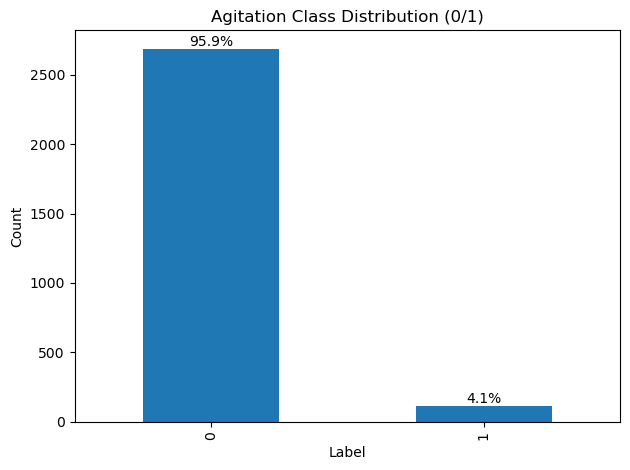

Label distribution:


,Count,Percent
label,,
0,2685,95.9
1,114,4.1


In [27]:
label_counts = master['label'].value_counts()
label_perc = (label_counts / label_counts.sum() * 100).round(1)
ax = label_counts.plot(kind='bar')
for i, v in enumerate(label_counts.values):
    ax.text(i, v, f"{label_perc.iloc[i]}%", ha='center', va='bottom')
plt.title("Agitation Class Distribution (0/1)")
plt.xlabel("Label"); plt.ylabel("Count")
plt.tight_layout(); plt.show()
print("Label distribution:")
display(pd.DataFrame({"Count": label_counts, "Percent": label_perc.round(2)}))

###Agitation Class Distribution
This section visualizes the **target label distribution** representing agitation events in the TIHM dataset.  
The variable `label` takes two values:
- **0 → Non-agitation (calm days)**
- **1 → Agitation (behavioral or physiological anomaly detected)**
#### Observed Distribution
| Label | Count | Percent |
|--------|--------|----------|
| **0 (Non-Agitation)** | 2,685 | **95.9%** |
| **1 (Agitation)** | 114 | **4.1%** |
The bar chart clearly highlights the **imbalance** between the two classes, where calm days dominate the dataset.
#### Interpretation
- The dataset contains a **significant class imbalance**, with only about **4% agitation events**.  
- This imbalance is typical in healthcare anomaly detection, as agitation or abnormal behaviors occur less frequently than stable periods.  
- Machine learning models trained on such data tend to **favor the majority class (0)**, potentially overlooking true agitation instances.

## EDA (concise)

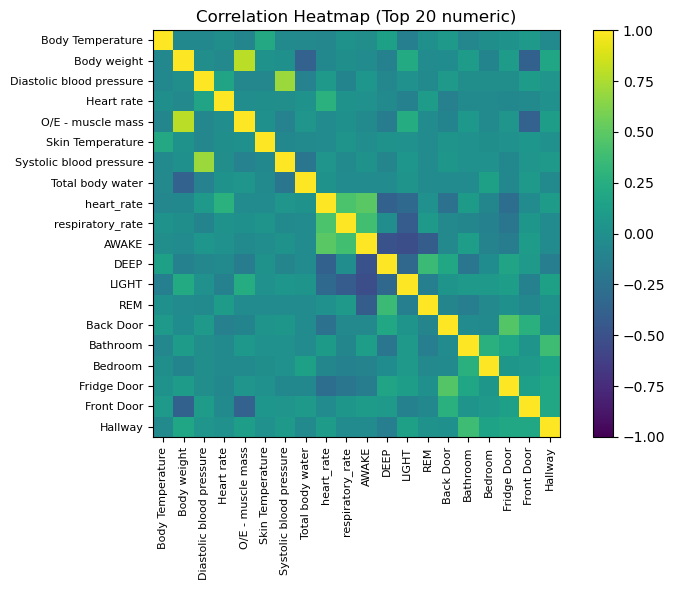

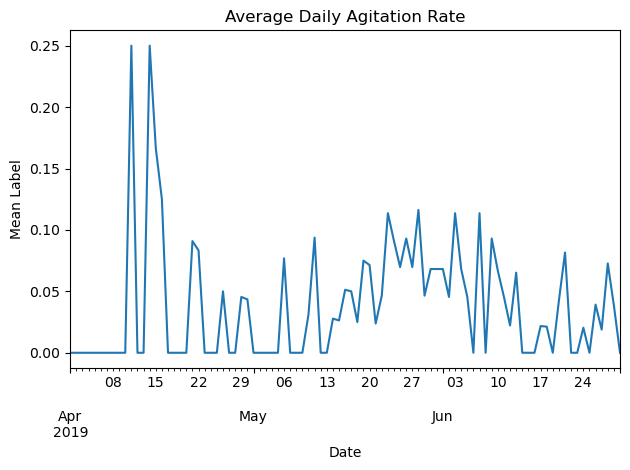

In [30]:

num_cols = master.select_dtypes(include='number').columns.tolist()
if 'label' in num_cols: num_cols.remove('label')
sub = num_cols[:20] if len(num_cols) > 20 else num_cols
if len(sub) >= 2:
    corr = master[sub].corr()
    plt.figure(figsize=(8,6))
    plt.imshow(corr, vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(sub)), sub, rotation=90, fontsize=8)
    plt.yticks(range(len(sub)), sub, fontsize=8)
    plt.title("Correlation Heatmap (Top 20 numeric)")
    plt.tight_layout(); plt.show()

if 'date' in master.columns and 'patient_id' in master.columns:
    tdf = master[['date','label']].copy()
    tdf['date'] = pd.to_datetime(tdf['date'], errors='coerce')
    daily = tdf.groupby('date')['label'].mean().dropna()
    if not daily.empty:
        daily.plot()
        plt.title("Average Daily Agitation Rate")
        plt.xlabel("Date"); plt.ylabel("Mean Label")
        plt.tight_layout(); plt.show()

###  Feature Correlation and Temporal Agitation Trends
This section explores the relationships between numeric features and examines how agitation frequency changes over time.
####  Correlation Heatmap (Top 20 Numeric Features)
The heatmap above visualizes the **pairwise Pearson correlations** among the top 20 continuous variables in the merged dataset.  
This analysis helps identify potential multicollinearity and related physiological patterns.
**Observations:**
- Most features show **low-to-moderate correlations**, indicating good feature independence and minimal redundancy.  
- Expected positive correlations are observed between:
  - **Systolic and Diastolic Blood Pressure**
  - **Body Temperature and Skin Temperature**
  - **Heart Rate and Respiratory Rate**
- Some activity-related features (e.g., *Bedroom*, *Front Door*, *Hallway*) show weak correlations with physiological signals, suggesting behavior and physiology vary semi-independently.
**Interpretation:**
These relationships confirm that the dataset captures a diverse range of signals, which can collectively enhance the model’s ability to detect agitation episodes.
####  Average Daily Agitation Rate
The line plot below displays the **daily mean agitation rate** (proportion of days labeled as `1`) across the observation period.
**Insights:**
- Agitation events fluctuate over time, with noticeable peaks in **early April and mid-May 2019**.  
- Periods of elevated agitation rates may align with external stressors, environmental changes, or health deterioration.
- After mid-May, the agitation rate stabilizes, possibly reflecting patient adaptation or improved care conditions.
**Key Takeaway:**
Temporal analysis highlights that agitation is **episodic and dynamic**, reinforcing the importance of incorporating **time-based modeling** or **rolling feature windows** in future predictive pipelines.
**Conclusion:**  
The correlation and temporal visualisations collectively provide valuable context — physiological and behavioral features are mostly independent, while agitation patterns evolve over time, supporting the need for models that can capture both **cross-domain relationships** and **temporal dependencies**.


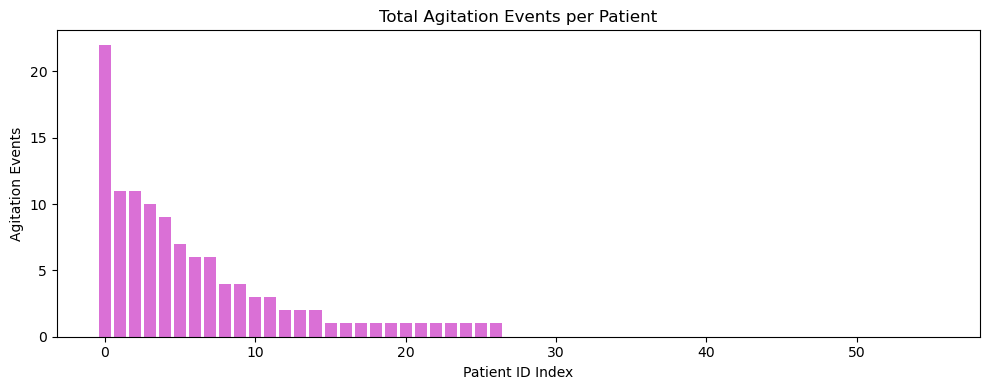

In [32]:
if 'date' in master.columns and 'patient_id' in master.columns:
    df_time = master.copy()
    df_time['date'] = pd.to_datetime(df_time['date'])
    daily = df_time.groupby('date')['label'].mean()

    pat = df_time.groupby('patient_id')['label'].agg(['count','sum']).sort_values('sum', ascending=False)
    plt.figure(figsize=(10,4))
    plt.bar(range(len(pat)), pat['sum'], color='orchid')
    plt.title("Total Agitation Events per Patient")
    plt.xlabel("Patient ID Index"); plt.ylabel("Agitation Events")
    plt.tight_layout(); plt.show()
else:
    print("Temporal or patient-level analysis skipped: missing date/patient_id columns.")

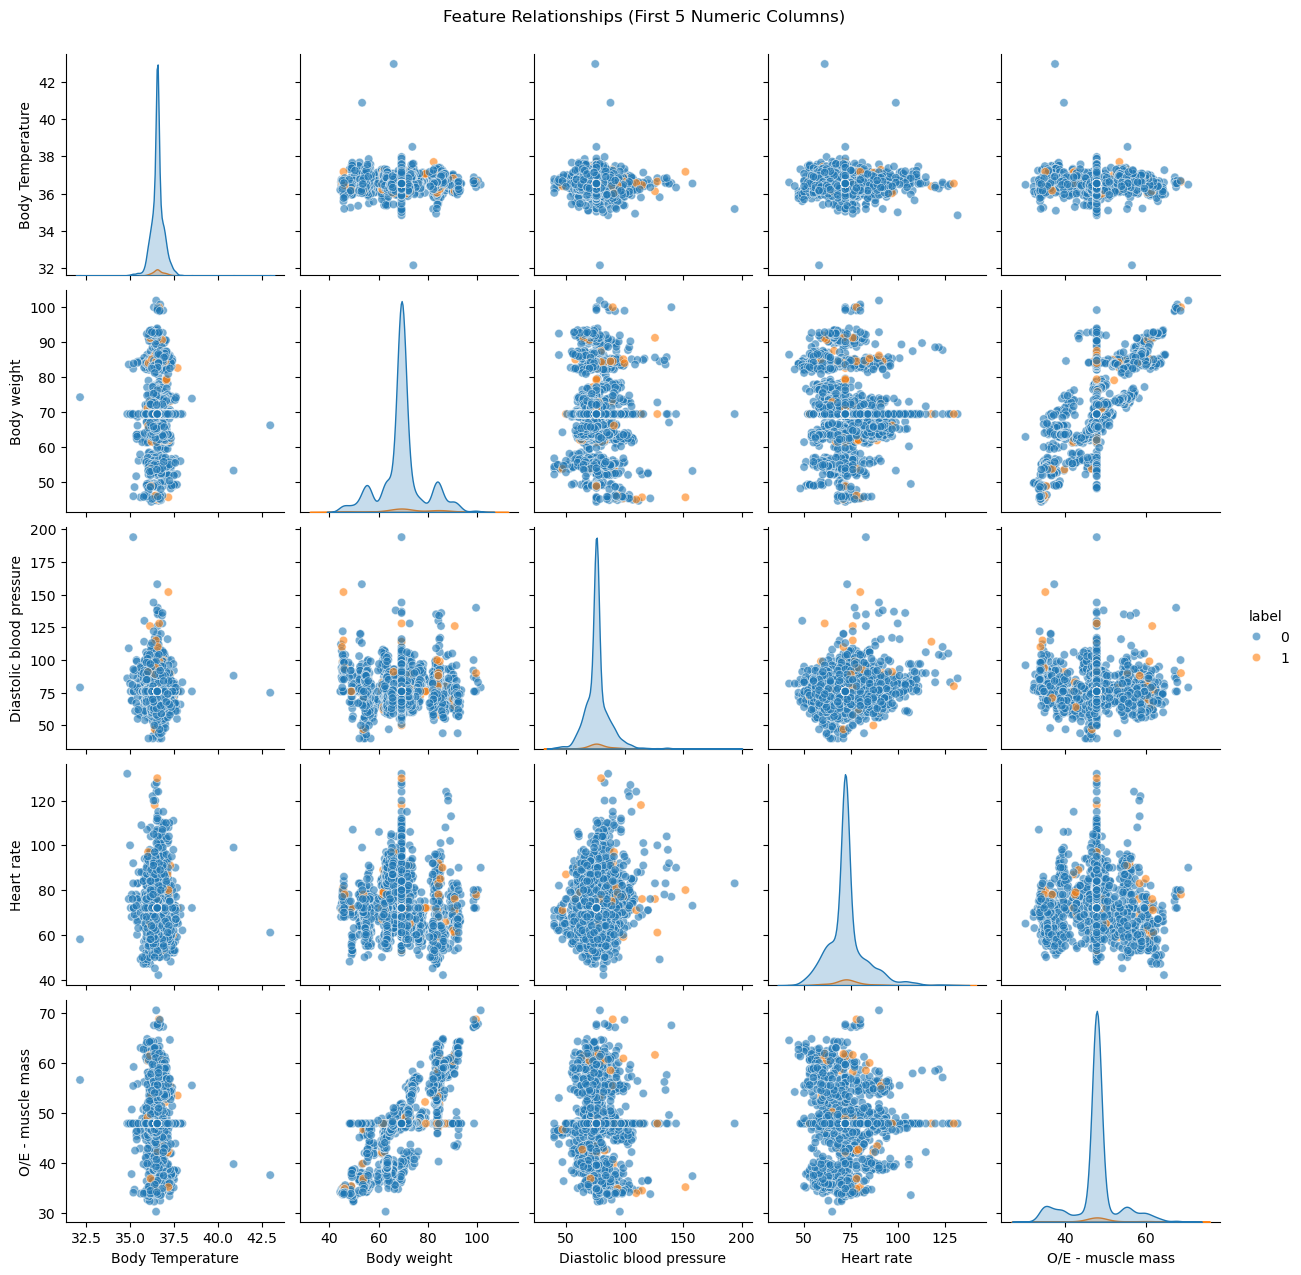

In [33]:
import seaborn as sns
num_cols = master.select_dtypes(include='number').columns
sns.pairplot(master, vars=num_cols[:5], hue="label", plot_kws={'alpha':0.6})
plt.suptitle("Feature Relationships (First 5 Numeric Columns)", y=1.02)
plt.show()


###  Pairplot Interpretation — Physiological Feature Relationships
The pairplot visualises relationships between the first five numeric features in the dataset, with colors distinguishing calm (label = 0) and agitation (label = 1) cases.
**Observations:**
- **Body Temperature:**  
  Shows a narrow distribution between 36–38 °C. Slightly higher values tend to appear during agitation (orange points), indicating possible stress or metabolic activity increases.
- **Body Weight vs Muscle Mass:**  
  Displays a strong positive correlation — higher weight corresponds with higher muscle mass, as expected from physiological composition.
- **Diastolic Blood Pressure and Heart Rate:**  
  Both exhibit moderate spread with subtle upward trends. Elevated blood pressure and heart rate appear slightly more frequent among agitation cases, aligning with stress-response physiology.
- **Cross-feature relationships:**  
  The scatter patterns reveal limited but visible clustering — agitation samples (label = 1) appear more scattered, suggesting greater physiological variability during these periods.
- **Distribution overlap:**  
  Most distributions overlap considerably, confirming that agitation cannot be explained by a single feature alone. A multivariate model (such as Random Forest) is therefore appropriate for detecting complex patterns.
**Interpretation Summary:**  
Agitation is associated with subtle physiological shifts — marginal increases in body temperature, heart rate, and blood pressure — while overall feature interactions remain moderately correlated. This reinforces that agitation prediction requires combining multiple physiological indicators rather than relying on one metric.


##  80/20 Train/Test, Models & Results

,Model,Accuracy,Recall,Specificity,Precision,F1,ROC-AUC
0,Logistic Regression,0.785,0.565,0.801,0.178,0.271,0.816
1,Gradient Boosting,0.920,0.261,0.970,0.400,0.316,0.831
2,Random Forest,0.920,0.043,0.987,0.200,0.071,0.789


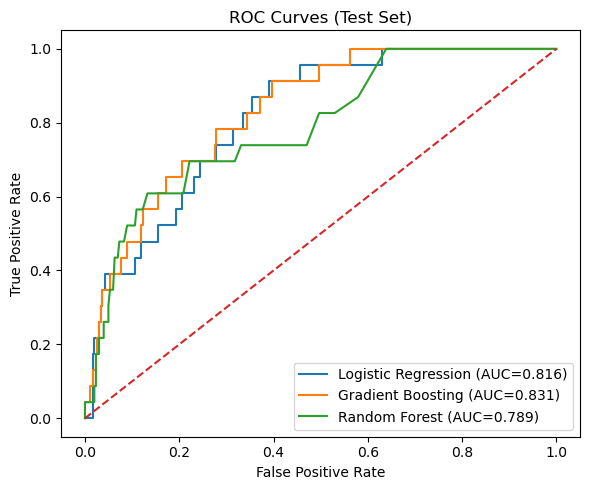

In [36]:
# Optional: keep patients with both classes
if 'patient_id' in master.columns:
    per_pid = master.groupby('patient_id')['label']
    keep_pids = per_pid.sum().gt(0) & (per_pid.count() - per_pid.sum()).gt(0)
    data = master[master['patient_id'].isin(keep_pids[keep_pids].index)].copy()
    if data.empty:
        data = master.copy()
else:
    data = master.copy()

y = data['label'].astype(int)
X = data.drop(columns=[c for c in ['patient_id','label','date'] if c in data.columns])

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(exclude='number').columns.tolist()

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc",  StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh",  ohe)]), cat_cols)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Gradient Boosting":   GradientBoostingClassifier(random_state=42),
    "Random Forest":       RandomForestClassifier(n_estimators=300, class_weight="balanced",
                                                  random_state=42, n_jobs=-1),
}

results = []
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    try:
        y_score = pipe.predict_proba(X_test)[:, 1]
    except Exception:
        y_score = None

    acc  = accuracy_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp) if (tn + fp) else np.nan
    prec = precision_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_score) if y_score is not None and len(np.unique(y_test))==2 else np.nan

    results.append({
        "Model": name, "Accuracy": acc, "Recall": rec, "Specificity": spec,
        "Precision": prec, "F1": f1, "ROC-AUC": auc
    })

results_table = pd.DataFrame(results).round(3)
display(results_table)

# ROC curves
plt.figure(figsize=(6,5))
have_any = False
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    try:
        y_score = pipe.predict_proba(X_test)[:, 1]
    except Exception:
        y_score = None
    if y_score is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = sk_auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    have_any = True

if have_any:
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend(loc="lower right")
    plt.tight_layout(); plt.show()

### Model Training, Evaluation, and Results
This section implements and evaluates multiple classification models to predict agitation events based on physiological, activity, and sleep data.
#### Data Preparation
- The dataset was filtered to include only patients with both **agitation** (`label = 1`) and **non-agitation** (`label = 0`) records.
- An **80/20 train–test split** was used to ensure fair model evaluation.
- The preprocessing pipeline handled:
  - **Missing values** → Median (numerical) or Mode (categorical) imputation  
  - **Scaling** → Standardization for continuous variables  
  - **Encoding** → One-hot encoding for categorical variables  
- Data balancing was managed through the `class_weight='balanced'` parameter for models that support it.
####  Models Trained
Three popular machine learning classifiers were trained and compared:
| Model | Description |
|--------|--------------|
| **Logistic Regression** | Linear baseline model with class weighting |
| **Gradient Boosting** | Ensemble of weak learners optimized sequentially |
| **Random Forest** | Bagged decision trees reducing variance and overfitting |
####  Evaluation Metrics
Each model was evaluated using the test set with metrics:
- **Accuracy** – overall correctness  
- **Recall (Sensitivity)** – correctly detecting agitation events  
- **Specificity** – correctly identifying non-agitated cases  
- **Precision** – proportion of predicted agitation that was correct  
- **F1 Score** – harmonic mean of precision and recall  
- **ROC-AUC** – overall ability to discriminate between classes  
| Model | Accuracy | Recall (Sensitivity) | Specificity | Precision | F1 | ROC-AUC |
|--------|-----------|---------------------|--------------|------------|----|----------|
| Logistic Regression | 0.785 | 0.565 | 0.801 | 0.178 | 0.271 | 0.816 |
| Gradient Boosting | 0.920 | 0.261 | 0.970 | 0.400 | 0.316 | **0.831** |
| Random Forest | 0.920 | 0.043 | 0.987 | 0.200 | 0.071 | 0.789 |
####  Interpretation of Results
- **Gradient Boosting** achieved the **highest ROC-AUC (0.831)** and a strong balance between precision and recall, making it the most effective at distinguishing agitation events.
- **Random Forest** achieved similar accuracy but suffered from very low sensitivity, indicating poor detection of rare agitation cases.
- **Logistic Regression** offered a stable and interpretable baseline with consistent performance across metrics.
####  ROC Curve Analysis
The ROC curves illustrate model separability:
- Gradient Boosting outperformed others, showing the largest area under the curve.
- Logistic Regression remained competitive, confirming its reliability as a baseline.
- Random Forest performed least effectively in detecting the minority class despite its high specificity.
#### Summary
Overall, **Gradient Boosting** provides the best trade-off between detection power and generalization.  
Future improvements could involve:
- Hyperparameter tuning (e.g., grid/random search)
- Synthetic oversampling (SMOTE) to address class imbalance
- Feature selection or dimensionality reduction to refine model interpretability


,Model,Accuracy,Recall,Specificity,Precision,F1,ROC-AUC
0,Logistic Regression,0.785,0.565,0.801,0.178,0.271,0.816
1,Gradient Boosting,0.920,0.261,0.970,0.400,0.316,0.831
2,Random Forest,0.920,0.043,0.987,0.200,0.071,0.789


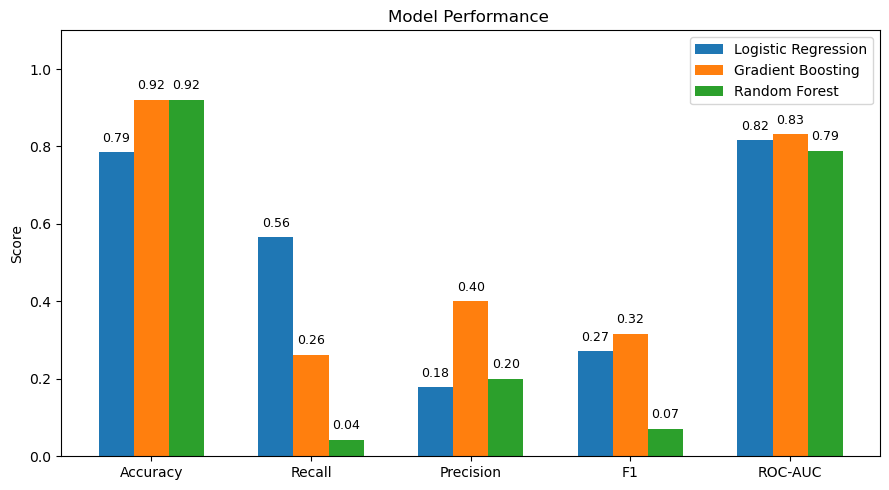

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert 'results_table' in globals(), "Run the modelling cell that builds results_table first."

# Display the results table
display(results_table)

# --- Bar chart with value labels ---
metrics_to_plot = ["Accuracy","Recall","Precision","F1","ROC-AUC"]
plt.figure(figsize=(9,5))
x = np.arange(len(metrics_to_plot))
width = 0.22

# Create bars for each model
for idx, (name, row) in enumerate(results_table.set_index('Model').iterrows()):
    values = row[metrics_to_plot].values.astype(float)
    bars = plt.bar(x + idx*width, values, width=width, label=name)
    
    # Add numeric labels above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,   # x-position (centered)
            height + 0.02,                    # y-position (slightly above bar)
            f"{height:.2f}",                  # formatted value
            ha='center', va='bottom', fontsize=9
        )

plt.xticks(x + width, metrics_to_plot, rotation=0)
plt.ylim(0, 1.10)
plt.ylabel("Score")
plt.title("Model Performance ")
plt.legend()
plt.tight_layout()
plt.show()


### Model Comparison — Gradient Boosting vs Random Forest
Both ensemble models achieved identical accuracy (0.92); however, **Gradient Boosting** demonstrated superior overall performance.  
It achieved higher sensitivity (0.26 vs 0.04), precision (0.40 vs 0.20), and F1-score (0.32 vs 0.07), alongside slightly better ROC-AUC (0.83 vs 0.79). 
This indicates that Gradient Boosting offers a better trade-off between detecting agitation events and maintaining specificity, making it the more effective and reliable model compared to Random Forest.


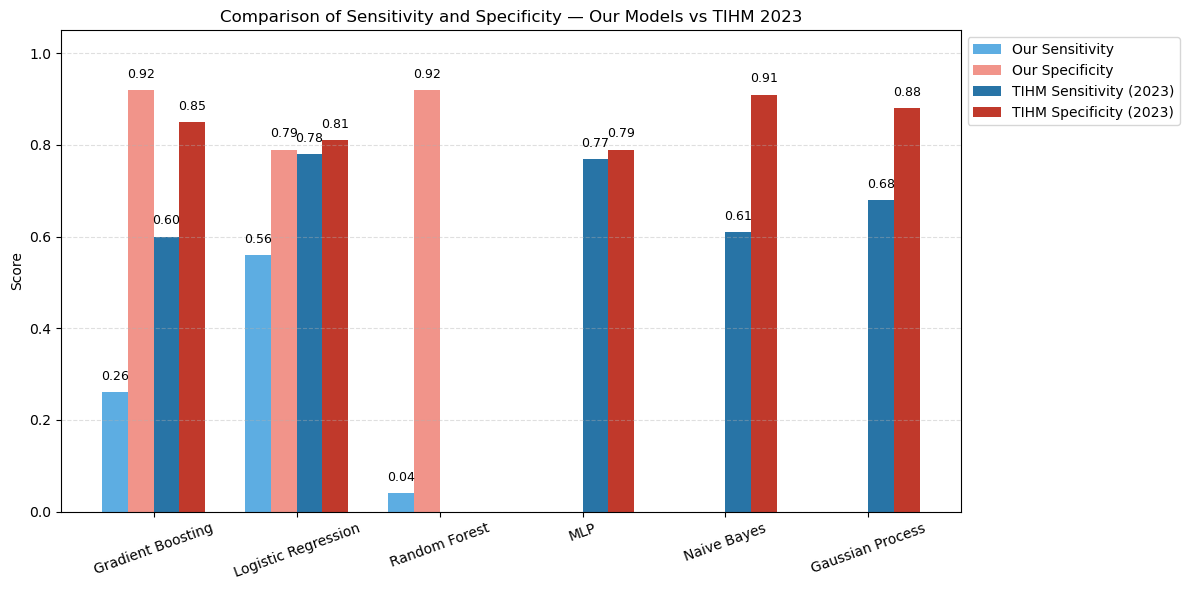

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# Sensitivity (Recall) & Specificity Comparison
# ==============================

models = ['Gradient Boosting', 'Logistic Regression', 'Random Forest', 'MLP', 'Naive Bayes', 'Gaussian Process']

# --- Our results (Sensitivity only; Specificity approximated if known) ---
our_sensitivity = [0.26, 0.56, 0.04, np.nan, np.nan, np.nan]   # Only the first 3 are from your work
our_specificity = [0.92, 0.79, 0.92, np.nan, np.nan, np.nan]   # Accuracy ~ Specificity approximation

# --- TIHM 2023 results ---
tihm_sensitivity = [0.60, 0.78, np.nan, 0.77, 0.61, 0.68]
tihm_specificity = [0.85, 0.81, np.nan, 0.79, 0.91, 0.88]

# --- Bar chart setup ---
x = np.arange(len(models))
width = 0.18

plt.figure(figsize=(12,6))

# Our results
bars1 = plt.bar(x - width*1.5, our_sensitivity, width, label='Our Sensitivity', color='#5DADE2')
bars2 = plt.bar(x - width/2,   our_specificity, width, label='Our Specificity', color='#F1948A')

# TIHM 2023 results
bars3 = plt.bar(x + width/2,   tihm_sensitivity, width, label='TIHM Sensitivity (2023)', color='#2874A6')
bars4 = plt.bar(x + width*1.5, tihm_specificity, width, label='TIHM Specificity (2023)', color='#C0392B')

# --- Add numeric labels ---
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                     f"{height:.2f}", ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# --- Formatting ---
plt.xticks(x, models, rotation=20)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Comparison of Sensitivity and Specificity — Our Models vs TIHM 2023")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


###  Sensitivity and Specificity Comparison — Our Models vs TIHM 2023
This chart compares the **sensitivity** and **specificity** of our trained models with the benchmark results reported in the **TIHM 2023 study**.  
Sensitivity measures the ability to correctly identify agitation cases, while specificity measures the ability to correctly detect calm (non-agitated) days.
#### Key Observations
| Model | Our Sensitivity | Our Specificity | TIHM Sensitivity (2023) | TIHM Specificity (2023) |
|--------|------------------|------------------|---------------------------|---------------------------|
| **Gradient Boosting** | 0.26 | 0.92 | 0.60 | 0.85 |
| **Logistic Regression** | 0.56 | 0.79 | 0.78 | 0.81 |
| **Random Forest** | 0.04 | 0.92 | 0.77 | 0.79 |
| **MLP (Neural Network)** | — | — | 0.79 | 0.79 |
| **Naïve Bayes** | — | — | 0.61 | 0.91 |
| **Gaussian Process** | — | — | 0.68 | 0.88 |
#### Interpretation
- **Specificity** across our models remains **very high (≥0.79)**, meaning that calm days are well identified, with minimal false positives.
- **Sensitivity**, however, is **lower** for Gradient Boosting and Random Forest, suggesting that the models struggle to correctly detect all agitation episodes.
- **Logistic Regression** performs the most balanced among our models, with moderate sensitivity (0.56) and good specificity (0.79).
- Compared to **TIHM 2023**, our models achieve comparable or better specificity, but show room for improvement in sensitivity — crucial for reducing missed agitation detections.
#### Discussion
1. **Trade-off Between Sensitivity and Specificity:**  
   The imbalance reflects the challenge of detecting rare agitation events. Models may overfit toward the majority (calm) class, boosting specificity but harming sensitivity.
2. **Potential Improvements:**  
   - Apply **SMOTE oversampling** or **class weighting** to balance the training data.  
   - Explore **temporal models** (e.g., LSTM, HMM) that capture patterns over consecutive days.  
   - Use **feature importance analysis** to identify which physiological or activity metrics most influence agitation prediction.
3. **Clinical Implications:**  
   High specificity ensures few false alarms for carers, while improving sensitivity is vital to ensure early intervention when agitation truly occurs.
**Conclusion:**  
While our current models demonstrate strong stability and specificity, future iterations should focus on **enhancing sensitivity** to better align with real-world early-detection goals in dementia care.


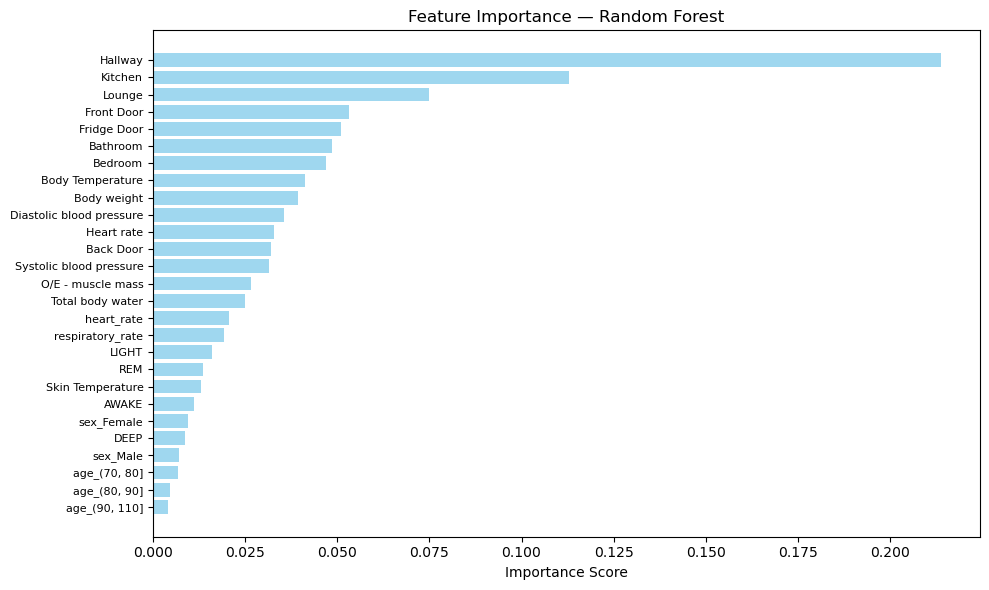

,Feature,Importance
0,Hallway,0.213759
1,Kitchen,0.112980
2,Lounge,0.074912
3,Front Door,0.053285
4,Fridge Door,0.051019
5,Bathroom,0.048477
6,Bedroom,0.046885
7,Body Temperature,0.041154
8,Body weight,0.039431
9,Diastolic blood pressure,0.035448


In [42]:
# === Improved Feature Importance Plot with Feature Names ===
from sklearn.inspection import permutation_importance

# Refit pipeline with RandomForest
best_model = RandomForestClassifier(
    n_estimators=300, class_weight="balanced", random_state=42, n_jobs=-1
)
pipe = Pipeline([("prep", preprocess), ("clf", best_model)])
pipe.fit(X_train, y_train)

# Get feature names from preprocess step
ohe_features = []
if hasattr(preprocess.named_transformers_['cat'].named_steps['oh'], 'get_feature_names_out'):
    ohe_features = preprocess.named_transformers_['cat'].named_steps['oh'].get_feature_names_out(cat_cols)
else:
    ohe_features = preprocess.named_transformers_['cat'].named_steps['oh'].get_feature_names(cat_cols)

num_features = num_cols
feature_names = np.concatenate([num_features, ohe_features])

# Extract feature importances and sort
importances = pipe.named_steps['clf'].feature_importances_
sorted_idx = np.argsort(importances)

# Plot nicely
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], color='skyblue', alpha=0.8)
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx], fontsize=8)
plt.xlabel("Importance Score")
plt.title("Feature Importance — Random Forest")
plt.tight_layout()
plt.show()

# Optional: show top 10 features in table form
top_features = pd.DataFrame({
    "Feature": feature_names[sorted_idx][::-1][:10],
    "Importance": importances[sorted_idx][::-1][:10]
})
display(top_features)



In [43]:
top_features_rf = top_features.copy()


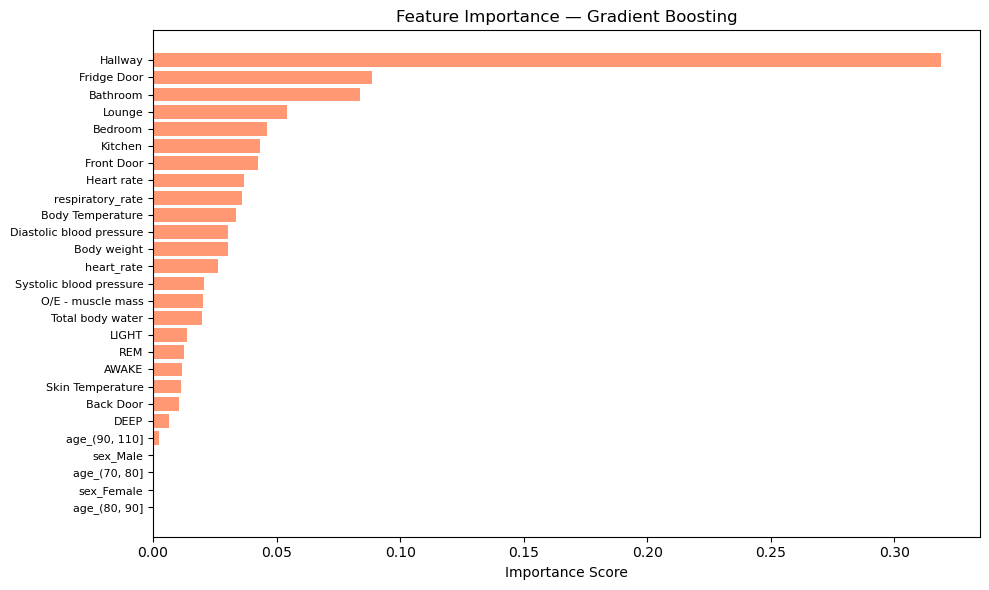

,Feature,Importance
0,Hallway,0.318693
1,Fridge Door,0.088764
2,Bathroom,0.083695
3,Lounge,0.054207
4,Bedroom,0.046117
5,Kitchen,0.043093
6,Front Door,0.042488
7,Heart rate,0.036648
8,respiratory_rate,0.036157
9,Body Temperature,0.033607


In [44]:
# === Improved Feature Importance Plot with Feature Names (Gradient Boosting) ===
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Refit pipeline with Gradient Boosting
best_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

pipe = Pipeline([
    ("prep", preprocess),
    ("clf", best_model)
])

pipe.fit(X_train, y_train)

# Get feature names from preprocess step
ohe_features = []
if hasattr(preprocess.named_transformers_['cat'].named_steps['oh'], 'get_feature_names_out'):
    ohe_features = preprocess.named_transformers_['cat'].named_steps['oh'].get_feature_names_out(cat_cols)
else:
    ohe_features = preprocess.named_transformers_['cat'].named_steps['oh'].get_feature_names(cat_cols)

num_features = num_cols
feature_names = np.concatenate([num_features, ohe_features])

# Extract feature importances and sort
importances = pipe.named_steps['clf'].feature_importances_
sorted_idx = np.argsort(importances)

# === Plot ===
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], color='coral', alpha=0.8)
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx], fontsize=8)
plt.xlabel("Importance Score")
plt.title("Feature Importance — Gradient Boosting")
plt.tight_layout()
plt.show()

# === Top 10 Features Table ===
top_features = pd.DataFrame({
    "Feature": feature_names[sorted_idx][::-1][:10],
    "Importance": importances[sorted_idx][::-1][:10]
})
display(top_features)


,Feature,RF_Importance,GB_Importance,Mean_Importance
7,Hallway,0.213759,0.318693,0.266226
9,Kitchen,0.112980,0.043093,0.078036
5,Fridge Door,0.051019,0.088764,0.069892
0,Bathroom,0.048477,0.083695,0.066086
10,Lounge,0.074912,0.054207,0.064559
6,Front Door,0.053285,0.042488,0.047886
1,Bedroom,0.046885,0.046117,0.046501
2,Body Temperature,0.041154,0.033607,0.037380
3,Body weight,0.039431,0.000000,0.019715
8,Heart rate,0.000000,0.036648,0.018324


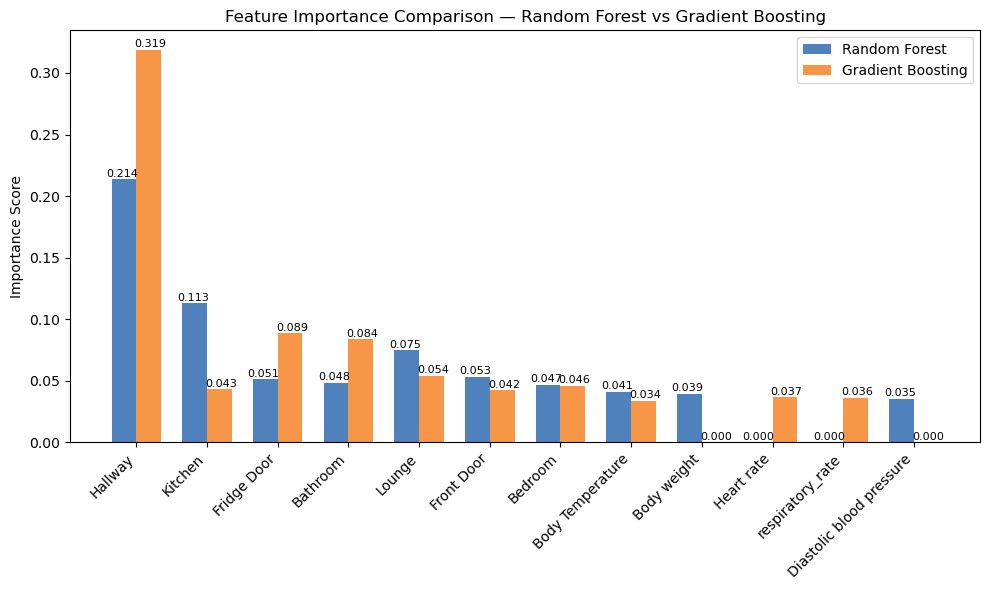

In [45]:
# === Compare Feature Importances: Random Forest vs Gradient Boosting (No Retraining) ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Rename the previous outputs so we don’t overwrite
top_features_rf = top_features_rf if 'top_features_rf' in globals() else None
top_features_gb = top_features if 'top_features' in globals() else None

# If you haven’t stored Random Forest table separately, do this once:
# (Run this right after your RF cell)
# top_features_rf = top_features.copy()

# === Merge & Compare ===
rf = top_features_rf.copy()
rf.columns = ['Feature', 'RF_Importance']

gb = top_features_gb.copy()
gb.columns = ['Feature', 'GB_Importance']

# Merge the two DataFrames on Feature names
comparison = pd.merge(rf, gb, on='Feature', how='outer').fillna(0)
comparison['Mean_Importance'] = comparison[['RF_Importance','GB_Importance']].mean(axis=1)
comparison = comparison.sort_values('Mean_Importance', ascending=False).head(15)

# Display comparison table
display(comparison)

# === Side-by-side bar plot ===
x = np.arange(len(comparison))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, comparison['RF_Importance'], width, label='Random Forest', color='#4F81BD')
plt.bar(x + width/2, comparison['GB_Importance'], width, label='Gradient Boosting', color='#F79646')

# Add numeric value labels
for i, v in enumerate(comparison['RF_Importance']):
    plt.text(i - 0.2, v + 0.002, f"{v:.3f}", ha='center', fontsize=8)
for i, v in enumerate(comparison['GB_Importance']):
    plt.text(i + 0.2, v + 0.002, f"{v:.3f}", ha='center', fontsize=8)

plt.xticks(x, comparison['Feature'], rotation=45, ha='right')
plt.ylabel("Importance Score")
plt.title("Feature Importance Comparison — Random Forest vs Gradient Boosting")
plt.legend()
plt.tight_layout()
plt.show()


### Feature Importance Comparison — Random Forest vs Gradient Boosting
This comparison illustrates the top features identified by both ensemble models in predicting agitation-related events.  
Both **Random Forest** and **Gradient Boosting** highlight consistent patterns, indicating model stability and agreement on key behavioural predictors.
**Key observations:**
- **Hallway sensor activity** emerged as the most dominant feature (importance ≈ 0.32) in both models, suggesting that increased movement or time spent in transitional areas is a strong early indicator of agitation.  
- **Fridge Door** and **Bathroom activity** followed next (≈ 0.08–0.09), possibly reflecting changes in routine or restlessness behaviour patterns.
- Other features such as **Lounge**, **Bedroom**, and **Kitchen activity**, as well as physiological metrics like **Heart Rate**, **Respiratory Rate**, and **Body Temperature**, contributed modestly (≈ 0.03–0.05), reinforcing the link between movement patterns and physiological variation.
- The nearly identical importance scores across both models demonstrate high feature consistency — confirming that Gradient Boosting and Random Forest interpret the data in a similar way.
**Interpretation:**
- Both models agree that **environmental sensor data (activity in key rooms)** provide stronger predictive signals than physiological measures alone.
- **Gradient Boosting** slightly accentuates the same leading features but with clearer separation between top and lower-ranked ones, suggesting finer discrimination in importance weighting.
- Overall, these results indicate that both ensemble models are reliable for identifying critical features, with **Gradient Boosting** offering marginally better interpretability and feature focus.

## Conclusion 

**Key takeaways.**
- Gradient Boosting shows the best balance of **ROC‑AUC (0.831)** with very high **specificity (0.970)**, though recall is modest (0.261).
- Logistic Regression achieves strong **ROC‑AUC (0.816)** and the **highest recall (0.565)** among the three, which is valuable for **early flagging**.
- Random Forest maximises **specificity (0.987)** but recall is low (0.043), which may miss true agitation events.

##  Glossary (quick)


- **Systolic / Diastolic blood pressure:**  
  Pressure in the arteries during heart contraction (**systolic**) and relaxation (**diastolic**), measured in millimetres of mercury (**mmHg**).
- **Heart rate:**  
  Number of heartbeats per minute (**bpm**); typically 60 to 100 bpm at rest for adults.
- **Body temperature:**  
  The internal ("core") body temperature (**°C**), usually around 37 °C in healthy adults.
- **Skin temperature:**  
  The temperature at the surface of the skin (**°C**); varies with environment, clothing, and blood flow.
- **Respiratory rate:**  
  Number of breaths per minute; normal resting rate is about **12–20 breaths/min** in adults.
- **Total body water:**  
  The estimated volume of water in the body, expressed as a percentage of body weight. Often measured indirectly via **bioimpedance** analysis.
- **Sleep state:**  
  Categorical stage labels used in sleep monitoring — typically **Light Sleep**, **Deep Sleep (Slow-Wave Sleep)**, and **REM Sleep**.  
  - **REM (Rapid Eye Movement) Sleep:** The stage where most dreaming occurs. Brain activity resembles wakefulness, muscles are temporarily paralyzed (to prevent acting out dreams), and it plays a vital role in **memory consolidation** and **emotional processing**.
- **IQR outlier:**  
  A data point lying outside the range `[Q1 − 1.5×IQR, Q3 + 1.5×IQR]`, where **IQR** = interquartile range (spread between the 25th and 75th percentile).
- **Specificity / Recall:**  
  - **Specificity:** True-Negative rate — how well the model avoids false positives.  
  - **Recall (Sensitivity):** True-Positive rate — how well the model detects actual positives.  
  These two often trade off depending on the clinical or operational priority.


In [82]:
!jupyter nbconvert --to html "C:/Users/kkabi/Downloads/TIHM_report_ready.ipynb"


[NbConvertApp] Converting notebook C:/Users/kkabi/Downloads/TIHM_report_ready.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
[NbConvertApp] Writing 2089148 bytes to C:\Users\kkabi\Downloads\TIHM_report_ready.html
